# Multi-Objective Evolutionary Algorithm
Paul TEMPLIER \
Pierre-Louis SAINT

## Multi-Objective Optimization 
\begin{matrix} min f_1(x), f_2(x)\\ x \in S \end{matrix}

## Pareto Optimum

#### Pareto Dominance

$x_1$ dominates $x_2$ if:

$$\forall i \in \{1, 2\}, f_i(x_1) <= f_i(x_2) $$
and $$\exists j \in \{1, 2\}, f_i(x_1) < f_i(x_2)$$

<center>
    
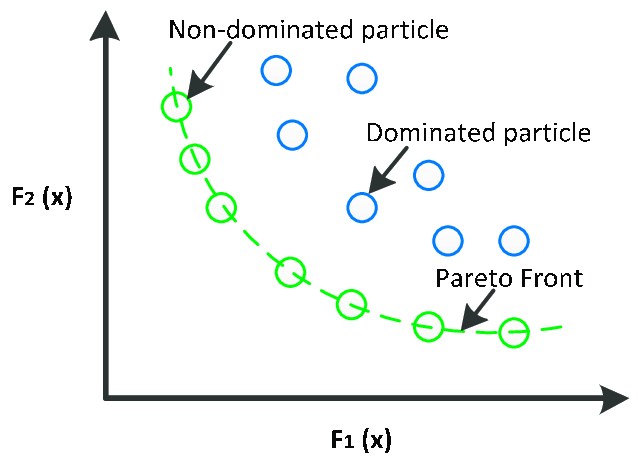

In [1]:
import numpy as np
import matplotlib.pyplot as plt
!pip install rise
import rise
import random as rd

## Population

In [2]:
n_pop = 100 
n_gen = 250
genome_size = 50

Pm = 0.2 # Mutate
Pr = 0.5 # Reproduce

### Individuals

Evaluation: 
$$ genome = [1, 1, 0, 1, 1, 0, 1, 1, 0, 1]$$
$$x = float(genome)$$


$$f_1(x) = x^2$$
$$f_2(x) = (x-2)^2$$


In [3]:
class individual:
    def __init__(self, genome=None):
        if genome is None :
            self.genome = np.random.randint(2, size=genome_size)
        else :
            self.genome = np.array(genome)
        self.y1 = None
        self.y2 = None
        self.fitness = None
        self.pareto = None
        self.eval()
            
    def __str__(self):
        return str(self.genome)
        
    def eval(self):
        i = int(genome_size / 2)
        mul = np.array([2**-i for i in range(i)])
        x = np.sum(np.multiply(self.genome[:i], mul), axis=0)/sum(mul) # x in [0, 1]
        x = 20 * x - 10 # x in [-10, 10]
        self.y1 = x**2
        self.y2 = (y-2)**2
        return self

In [4]:
    def __lt__(self, other):
        """ Less than: compares to another individual and returns True if self is better than other """
        return self.y1 < other.y1 and self.y2 < other.y2 and self != other
    
    def __add__(self, other):
        """ Reproduction """
        mask = np.random.randint(2, size=genome_size)
        parents = [self.genome, other.genome]
        child = individual(genome = [parents[mask[i]][i] for i in range(len(mask))])
        return child
    
    def __mul__(self, other):
        """ Mutation: other is the bit-wise mutation rate """
        mut = np.random.choice([0, 1], size=(genome_size,), p=[1-other, other])
        self.genome = [(1-mut[i]) * self.genome[i] + mut[i] * (1-self.genome[i]) for i in range(genome_size)]
        return self

In [5]:
class individual:
    def __init__(self, genome=None):
        if genome is None :
            self.genome = np.random.randint(2, size=genome_size)
        else :
            self.genome = np.array(genome)
        self.y1 = None
        self.y2 = None
        self.fitness = None
        self.pareto = None
        self.eval()
            
    def __str__(self):
        return str(self.genome)
        
    def eval(self):
        mul = np.array([2**-j for j in range(len(self.genome))])
        x = np.sum(np.multiply(self.genome, mul), axis=0)/sum(mul) # x in [0, 1]
        x = 20 * x - 10 # x in [-10, 10]
        self.y1 = x**2
        self.y2 = (x-2)**2
        return self
    
    def __lt__(self, other):
        """ Less than: compares to another individual and returns True if self is better than other """
        return ((self.y1 <= other.y1 and self.y2 < other.y2) or (self.y1 < other.y1 and self.y2 <= other.y2)) and self != other
    
    def __add__(self, other):
        """ Reproduction """
        mask = np.random.randint(2, size=genome_size)
        parents = [self.genome, other.genome]
        child = individual(genome = [parents[mask[i]][i] for i in range(len(mask))])
        return child
    
    def __mul__(self, other):
        """ Mutation: other is the bit-wise mutation rate """
        mut = np.random.choice([0, 1], size=(genome_size,), p=[1-other, other])
        self.genome = [(1-mut[i]) * self.genome[i] + mut[i] * (1-self.genome[i]) for i in range(genome_size)]
        return self

## Multi-objective Genetic Algorithm

### Non-Dominated Sorting

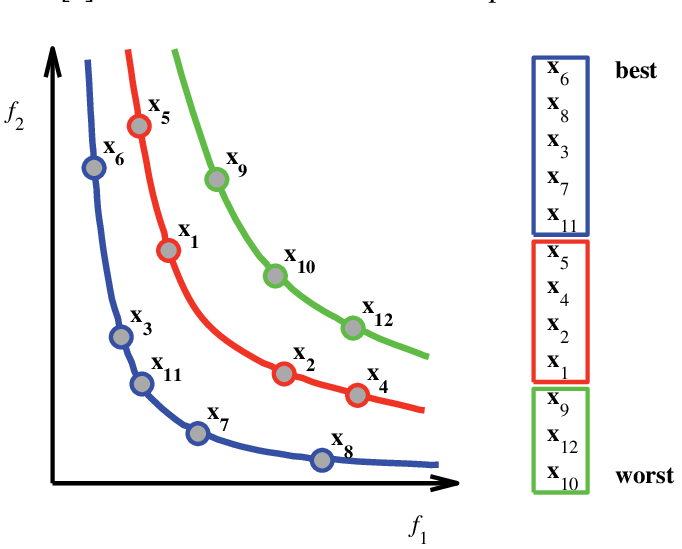

In [6]:
def NDS(population):
    """ Non-Dominated Sorting """
    N = len(population)
    paretos = {}
    p = 0
    while len(population) > 0 and p <= 100:
        new_pop = []
        new_pareto = []
        for i in range(len(population)):
            find_better = [j < population[i] for j in population]
            if True in find_better :
                new_pop.append(population[i])
            else:
                population[i].pareto = int(p)
                new_pareto.append(population[i])
        for indiv in new_pareto:
            if p==0:
                indiv.fitness = 1
            else:
                indiv.fitness = len(new_pop) / N
        population = new_pop
        paretos[p] = new_pareto
        p += 1
    return np.concatenate([paretos[x] for x in paretos])

### Fitness Proportionate Selection


In [7]:
def selection(population, mu=int(n_pop * 1)):
    f = [a.fitness for a in population] 
    if np.sum(f) >0:
        f = np.cumsum(f / np.sum(f))
    new_pop = []
    for _ in range(mu):
        i = np.where(f > rd.random())[0][0] 
        new_pop.append(population[i])
    return np.array(new_pop)

### Bit-wise Mutation

In [8]:
def mutation(population, proba=0.01):
    for p in population:
        p = p*proba
    return population

### Uniform Binary Crossing


In [9]:
def reproduction(population):
    children = []
    for p in population:
        r = rd.randint(0, len(population)-1)
        children.append(p + population[r])
    return np.array(children)

### Generation step


In [10]:
def generation(population, plot_graphs=True):
    population = NDS(population)
    population = selection (population)
    i_m = int(len(population) * Pm) # number mutate
    i_r = int(len(population) * Pr) # number reproduce
    i_s = len(population) - i_m - i_r # number survive
    p_s = population[:i_s]
    p_m = mutation(population[i_s:(i_s+i_r)])
    p_r = reproduction(population[(i_s+i_r):])
    population = np.append(p_s, p_m)
    population = np.append(population, p_r)
    if plot_graphs: 
        plot(population)
        histo_fit(population)
    return population

## Plotting

In [11]:
population = np.array([individual() for _ in range(n_pop)])
population = NDS(population)

### Objective functions values


In [12]:
def plot(pop, title=''):
    fig = plt.figure(figsize=(7, 7))
    d = np.array([[p.y1, p.y2, p.pareto] for p in pop])
    un = np.unique(d[:, 2].astype(int))
    for i in un:
        p = d[d[:, 2] == i]
        plt.scatter(p[:, 0], p[:, 1], label=i)
    #plt.legend()
    plt.title(title)
    plt.show()

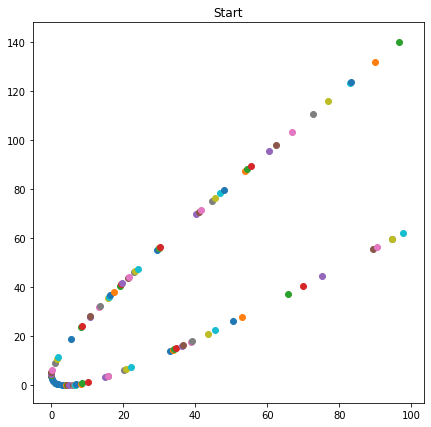

In [13]:
plot(population, title='Start')

### Pareto optima distribution


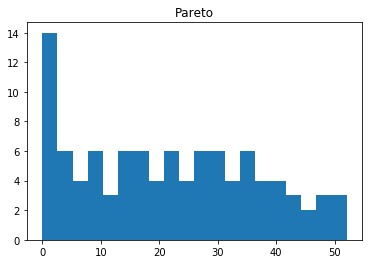

In [14]:
def histo_fit(population):
    plt.hist([a.pareto for a in population], bins=20)
    plt.title('Pareto')
    plt.show()

histo_fit(population)

## Run

In [15]:
def run():
    population = np.array([individual() for _ in range(n_pop)])
    population = NDS(population)
    yield population
    print('Generations')
    for g in range(n_gen):
        print(str(g+1) + '/' + str(n_gen), end='\r')
        population = generation(population, plot_graphs=False)
    population = NDS(population)
    yield population

## Init

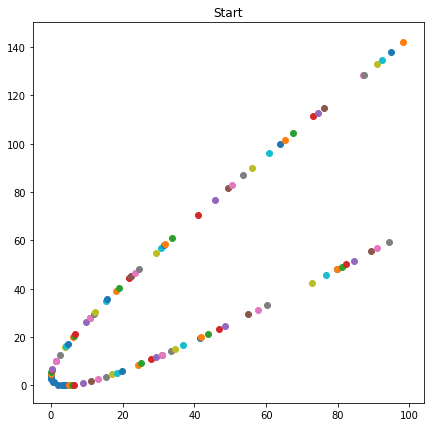

''

In [16]:
r = run()
p = r.__next__()
plot(p, title='Start')
""""""

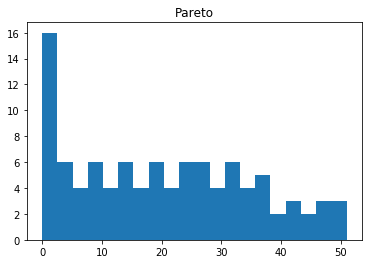

In [17]:
histo_fit(p)

## End

Generations


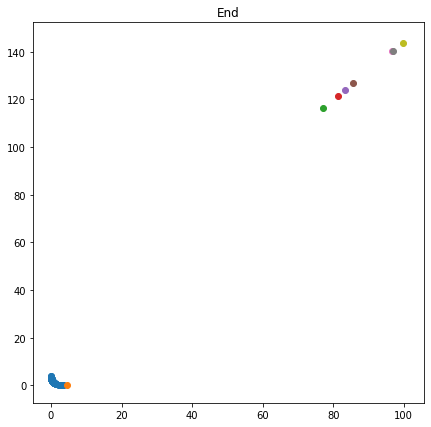

In [18]:
p = r.__next__()
plot(p, title='End')

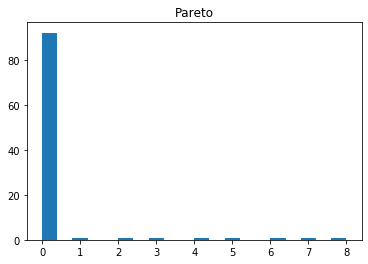

In [19]:
histo_fit(p)

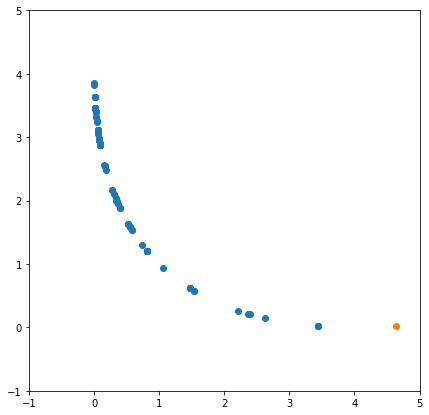

In [20]:
fig = plt.figure(figsize=(7, 7))
d = np.array([[a.y1, a.y2, a.pareto] for a in p])
un = np.unique(d[:, 2].astype(int))
for i in un:
    a = d[d[:, 2] == i]
    plt.scatter(a[:, 0], a[:, 1], label=i)
plt.xlim(-1, 5)
plt.ylim(-1, 5)
plt.show()

# Any questions?